## Modeling for predicting hospitalization at ED triage

Work Flow:
1. Task-specific filter
2. Variable selection
3. One-Hot-Encoding for Categorical Variable
3. Modeling script
4. Performance output

== Correlation analysis. Then do hyperparameter tuning.

Objective: To create a model that can predict a patient's need for hospital admission at the time of triage.

The **"time of triage"** is an important consideration as this would mean certain information "after the triage" (for e.g. ED length of stay) would not be available at that point.

### Load train and test

In [2]:
import os
import time
import pickle
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats as stats
from scipy.stats import spearmanr
from pprint import pprint

from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from keras.wrappers.scikit_learn import KerasClassifier


from helpers6 import PlotROCCurve

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, roc_auc_score,confusion_matrix, recall_score, f1_score, precision_score, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

In [3]:
output_path = 'C:\\Users\\kkb74\\Documents\\SMU Study\\ISSS623 - HealthCare Analytics\\Project\\Group Project Data'

path = output_path
df_train = pd.read_csv((os.path.join(path, 'train2.csv')))
df_test = pd.read_csv((os.path.join(path, 'test2.csv')))
confidence_interval = 95
random_seed=0

In [4]:
pd.set_option('display.max_columns', 135) 
pd.set_option('display.max_rows', 100) 
df_train.tail()

,index,subject_id,hadm_id,stay_id,intime_ed,outtime_ed,anchor_age,gender,anchor_year,dod,admittime,dischtime,deathtime,race,edregtime,edouttime,insurance,in_year,age,before_ed_mortality,outcome_hospitalization,outcome_inhospital_mortality,ed_death,ed_los,intime_icu,outtime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcomplaint,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
352624,174713,11388716,21251706.0,39845790,2144-05-25 14:52:00,2144-05-26 05:19:00,59.0,M,2142.0,NaN,2144-05-26 01:41:00,2144-05-30 15:44:00,NaN,WHITE,2144-05-25 14:52:00,2144-05-26 05:19:00,Other,2144,61.0,False,True,False,False,0 days 14:27:00,NaN,NaN,NaN,False,False,0,0,3,2144-06-16 17:53:00,21 days 12:34:00,False,0,0,3,0,0,0,14.45,NaN,21.52,36.166667,68.0,20.0,99.0,90.0,77.0,0.0,3.0,DIZZY,False,False,False,False,False,False,False,False,False,True,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,36.666667,87.0,16.0,97.0,121.0,79.0,4.0,3.0,8.0,81.333333,13,4,5,3,3,2
352625,248637,14492863,NaN,36305023,2195-08-01 15:08:00,2195-08-01 15:14:00,28.0,F,2191.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2195,32.0,False,False,False,False,0 days 00:06:00,NaN,NaN,NaN,False,False,0,0,0,NaN,NaN,False,0,0,0,0,0,0,0.10,NaN,NaN,37.000000,101.0,16.0,99.0,109.0,67.0,7.0,3.0,"FEVERS, BODY ACHES",False,False,False,False,False,False,False,True,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37.000000,98.0,20.0,99.0,110.0,69.0,0.0,5.0,0.0,81.000000,0,0,0,2,2,2
352626,86392,15298378,28968894.0,37032262,2162-01-07 15:21:00,2162-01-07 20:55:00,55.0,M,2162.0,NaN,2162-01-07 19:40:00,2162-01-09 16:15:00,NaN,WHITE,2162-01-07 15:21:00,2162-01-07 20:55:00,Other,2162,55.0,False,True,False,False,0 days 05:34:00,NaN,NaN,NaN,False,False,0,0,0,NaN,NaN,False,0,0,0,0,0,0,5.57,NaN,NaN,37.166667,57.0,16.0,94.0,127.0,89.0,5.0,3.0,"Abd pain, Nausea",False,True,False,False,False,False,True,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.777778,62.0,18.0,96.0,149.0,93.0,0.0,0.0,0.0,101.666667,1,4,5,1,0,1
352627,133042,13854344,NaN,33160200,2160-10-29 01:44:00,2160-10-29 03:02:00,31.0,M,2160.0,NaN,NaN,NaN,NaN,OTHER,NaN,NaN,NaN,2160,31.0,False,False,False,False,0 days 01:18:00,NaN,NaN,NaN,False,False,2,3,3,2160-11-09 16:18:00,11 days 13:16:00,False,2,2,2,0,0,0,1.30,NaN,11.55,35.555556,109.0,18.0,100.0,130.0,63.0,7.0,3.0,ABDOMINAL PAIN,False,True,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.888889,74.0,18.0,100.0,111.0,64.0,6.0,2.0,6.0,85.333333,0,0,0,2,2,2
352628,193726,14797164,23643435.0,3

### 1. task-specific filter: exclude ED death cases for train and test

In [5]:
# "ed_death" is a Boolean field that is marked if patient died in that ED encounter
# Need to also .reset the index() for df_train dataset as well after removing the records with 'ed_death' == True
df_train = df_train[df_train['ed_death'] == False].reset_index()
df_test = df_test[df_test['ed_death'] == False].reset_index()

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352628 entries, 0 to 352627
Columns: 128 entries, level_0 to score_MEWS
dtypes: bool(17), float64(25), int64(68), object(18)
memory usage: 304.3+ MB


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88157 entries, 0 to 88156
Columns: 128 entries, level_0 to score_MEWS
dtypes: bool(17), float64(25), int64(68), object(18)
memory usage: 76.1+ MB


### 2. Variable Selection

#### a. Default variables based on the sample codes

In [8]:

variable = [# Demographics
            "age", "gender", 
            
            # Past visits
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            # Triage Info
            "triage_temperature", "triage_heartrate", "triage_resprate", 
            "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity",
            
            # 10 compliant indicators
            # Complaints            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope", 
            "chiefcom_dizziness", 
            
            # 17 CCI indicators
            # Whether the CCI information is available at point of triage?
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", 
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", 
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", 
            "cci_Cancer2", "cci_HIV", 
            
            # 18 ECI indicators
            # 13 other ECI indicators not used
           
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2", 
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression"]

outcome = "outcome_hospitalization"

In [9]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [10]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression
0,float64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [11]:
y_train.value_counts()

False    185633
True     166995
Name: outcome_hospitalization, dtype: int64

### 3. Re-labeling of Categorical variable

#### a. Default variables using Label encoder for gender 

In [12]:
X_train_default = df_train[variable].copy()
y_train_default = df_train[outcome].copy()
X_test_default = df_test[variable].copy()
y_test_default = df_test[outcome].copy()

In [13]:
encoder = LabelEncoder()
X_train_default['gender'] = encoder.fit_transform(X_train_default['gender'])
X_test_default['gender'] = encoder.transform(X_test_default['gender'])

#### b. Default variables based on the sample codes

In [14]:
# Use one-hot encoding instead of label_encoder since gender is a nominal field

# Assign a list to capture all categorical variables
# more categorical variables can be added to this list
cat_features = ['gender']

enc = OneHotEncoder(drop='first') # first col dropped
enc.fit(X_train[cat_features])

# One-hot encoding for categorical variable in the train set
feature_enc_train = pd.DataFrame(enc.transform(X_train[cat_features]).toarray())
# Assign column header for the encoded field
feature_enc_train.columns = enc.get_feature_names_out(cat_features)
# drop original columns
X_train = X_train.drop(columns = cat_features)
# join dfs together
X_train = X_train.join(feature_enc_train) 

# One-hot encoding for categorical variable in the test set
feature_enc_test = pd.DataFrame(enc.transform(X_test[cat_features]).toarray())
feature_enc_test.columns = enc.get_feature_names_out(cat_features)
# drop original columns
X_test = X_test.drop(columns = cat_features)
# join dfs together
X_test = X_test.join(feature_enc_test) 


### 4. Feature Scaling of Numerical Variables

#### a. Default variables based on the sample codes

In [15]:
# List the numerical variables which require scaling
num_features = ['n_ed_30d', 'n_ed_90d', 'n_ed_365d', 'n_hosp_30d', 'n_hosp_90d',
       'n_hosp_365d', 'n_icu_30d', 'n_icu_90d', 'n_icu_365d',
       'triage_temperature', 'triage_heartrate', 'triage_resprate',
       'triage_o2sat', 'triage_sbp', 'triage_dbp', 'triage_pain',
       'triage_acuity']

# instantiate MinMaxScaler to normalise the numeric fields
minmax = MinMaxScaler()
minmax.fit(X_train[num_features])

# Feature scaling for train set
feature_scaling_train = pd.DataFrame(minmax.transform(X_train[num_features]))
feature_scaling_train.columns = num_features
X_train = X_train.drop(columns = num_features) # drop original columns
X_train = X_train.join(feature_scaling_train) # join dfs together

# Feature scaling for test set
feature_scaling_test = pd.DataFrame(minmax.transform(X_test[num_features]))
feature_scaling_test.columns = num_features
X_test = X_test.drop(columns = num_features) # drop original columns
X_test = X_test.join(feature_scaling_test) # join dfs together

In [16]:
# Check the shape of the datasets
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(352628, 64)
(88157, 64)
(352628,)
(88157,)


### 5.  Modeling

#### a. Logistic Regression

In [17]:
# Containers for all results
result_list = []

(i) Base Model as per sample codes

Logistic Regression:


C:\Users\kkb74\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 3.1905574798583984 seconds
AUC: 0.8076570981313992
AUPRC: 0.7749609427939819
Sensitivity: 0.7420005280971699
Specificity: 0.723923609617618
Score thresold: 0.4528091336611243
2.5 97.5


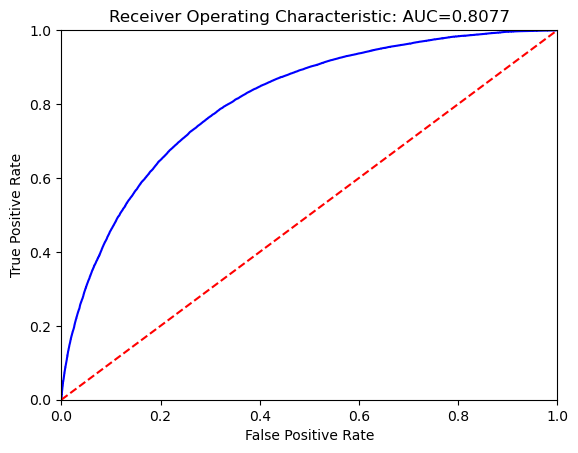

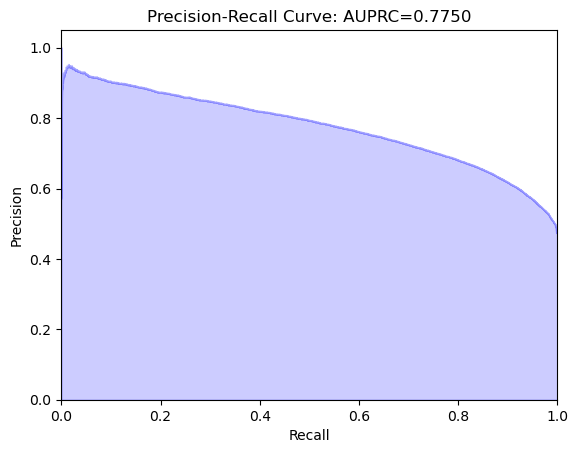

In [18]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=1234)
start = time.time()
logreg.fit(X_train_default,y_train_default)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test_default)
result = PlotROCCurve(probs[:,1],y_test_default, ci=confidence_interval)

results = ["LR_base"]
results.extend(result)
results.append(runtime)
result_list.append(results)

(ii) Base variables but applied one-hot encoding on "gender" and feature scale numeric variables

Logistic Regression:


C:\Users\kkb74\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 3.1646244525909424 seconds
AUC: 0.8014056811065047
AUPRC: 0.7674300197208448
Sensitivity: 0.7322307304544036
Specificity: 0.7194933115402813
Score thresold: 0.46202810732814287
2.5 97.5


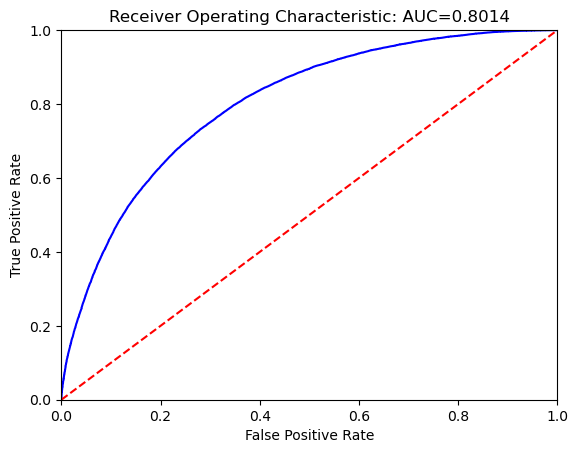

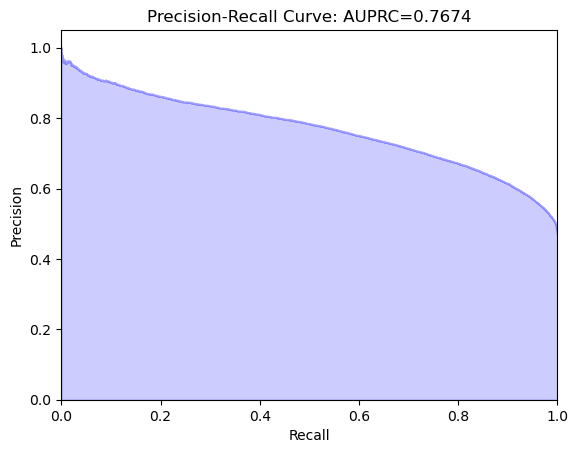

In [19]:
print("Logistic Regression:")

# Included Hyperparameters as indicated in the reference paper
logreg=LogisticRegression(penalty='l2',C=1.0, max_iter=100,random_state=1234)
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)

results = ["LR_base_variables_with_features_caling"]
results.extend(result)
results.append(runtime)
result_list.append(results)



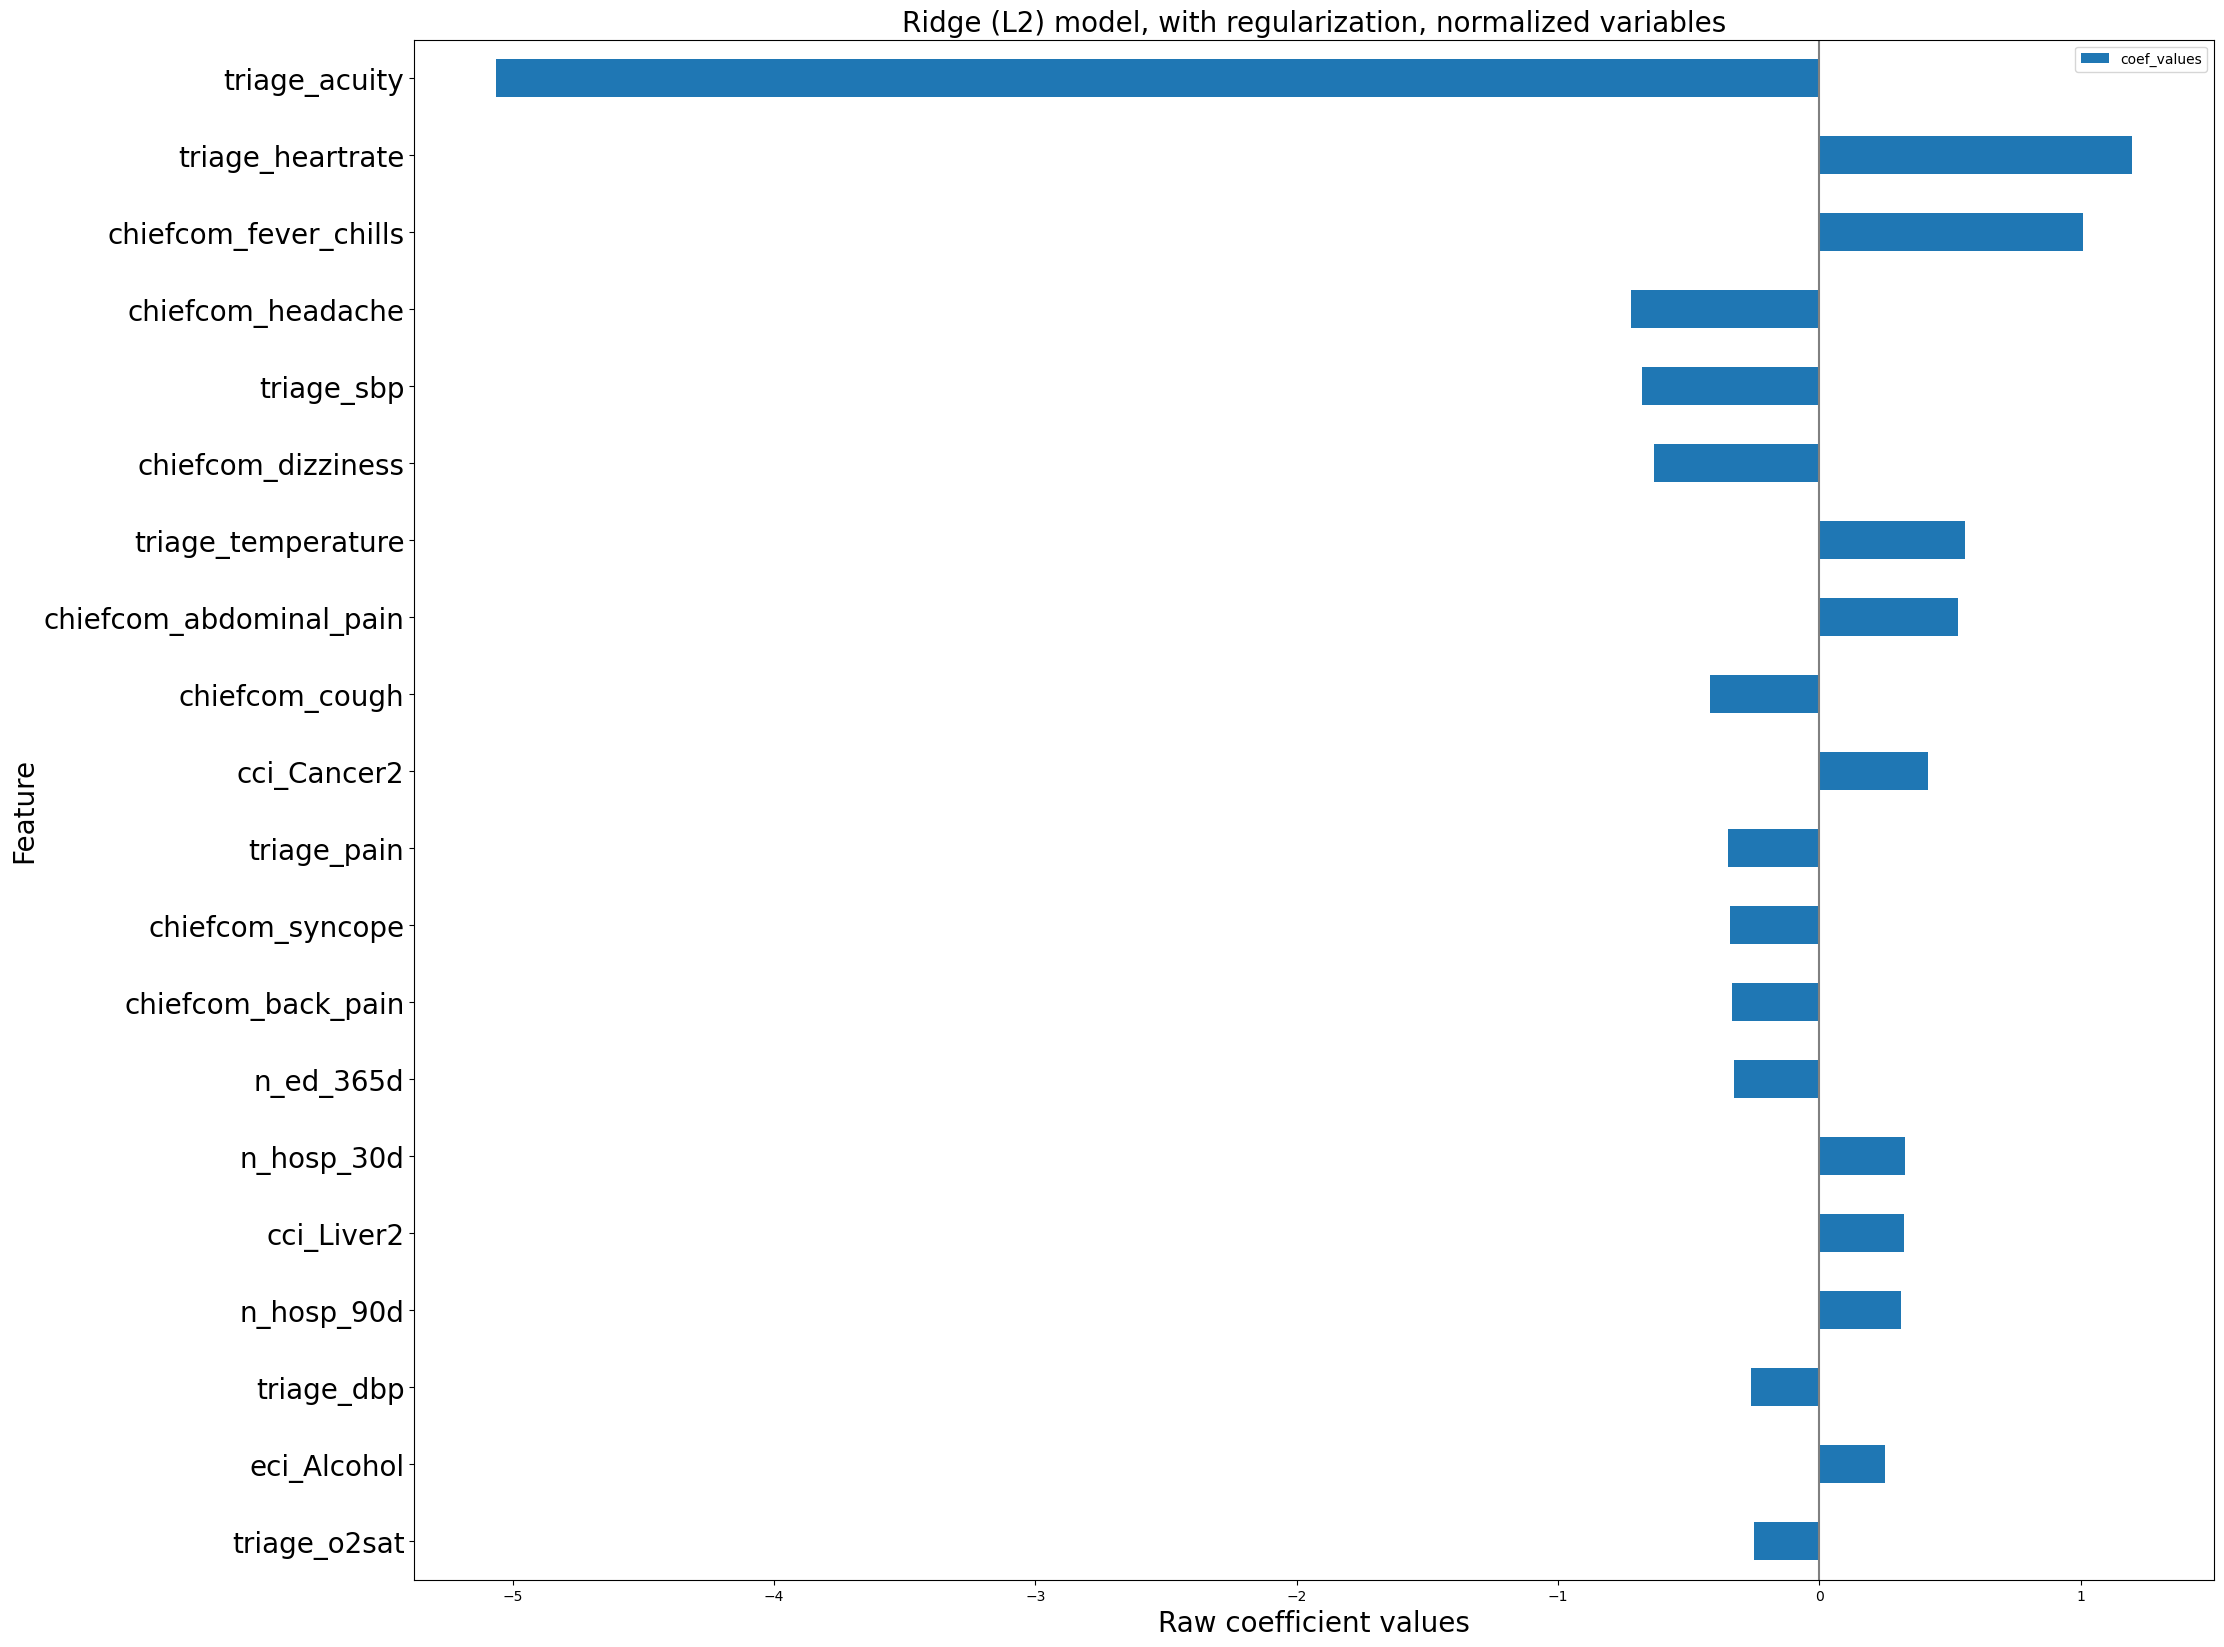

In [20]:
# Feature importance for LR model
logreg_coef = pd.DataFrame(
        {
            'features': np.array(X_train.columns),    
            'coef_values' : logreg.coef_.reshape(-1)
            })

sorted_coef = logreg_coef.sort_values(by='coef_values',key=lambda x:abs(x),ascending=False)[:20].set_index('features')

sorted_coef.sort_values(by='coef_values',key=lambda x:abs(x)).plot.barh(figsize=(30, 20))
plt.title("Ridge (L2) model, with regularization, normalized variables", fontsize=20)
plt.xlabel("Raw coefficient values", fontsize=20)
plt.ylabel('Feature',fontsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [23]:
# Feature importance for LR model
logreg_coef = pd.DataFrame(
        {
            'features': np.array(X_train.columns),    
            'coef_values' : logreg.coef_.reshape(-1)
            })

# Check top 20 features
logreg_coef.sort_values(by='coef_values',key=lambda x:abs(x),ascending=False)[:20]

,features,coef_values
63,triage_acuity,-5.064076
57,triage_heartrate,1.198229
8,chiefcom_fever_chills,1.010121
3,chiefcom_headache,-0.721877
60,triage_sbp,-0.677339
10,chiefcom_dizziness,-0.632412
56,triage_temperature,0.557089
2,chiefcom_abdominal_pain,0.532273
6,chiefcom_cough,-0.417460
26,cci_Cancer2,0.414808


(iii) Performance Output for LogReg modelling

In [24]:
#result_df = pd.read_csv(os.path.join(path, 'result_hospitalization_triage.csv'))
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
#result_df.to_csv(os.path.join(path, 'result_hospitalization_triage.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
#formatted_result_df.to_csv(os.path.join(path, 'task1.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,LR_base,0.453,0.808 (0.805-0.81),0.775 (0.77-0.778),0.742 (0.723-0.752),0.724 (0.717-0.741),3.191
1,LR_base_variables_with_features_caling,0.462,0.801 (0.798-0.804),0.767 (0.762-0.77),0.732 (0.726-0.737),0.719 (0.716-0.728),3.165


In [25]:
# Ouput formmatted_result_df to csv
formatted_result_df.to_csv(os.path.join(path, 'result_hospitalization_triage_logreg.csv'), index=False)

#### b. Random Forest

In [26]:
# Containers for all results
result_list_rf = []

(i) Base Model as per sample codes

RandomForest:
Training time: 89.67021775245667 seconds
AUC: 0.8194058781700774
AUPRC: 0.789613229310622
Sensitivity: 0.758443553613865
Specificity: 0.727644199750527
Score thresold: 0.484
2.5 97.5


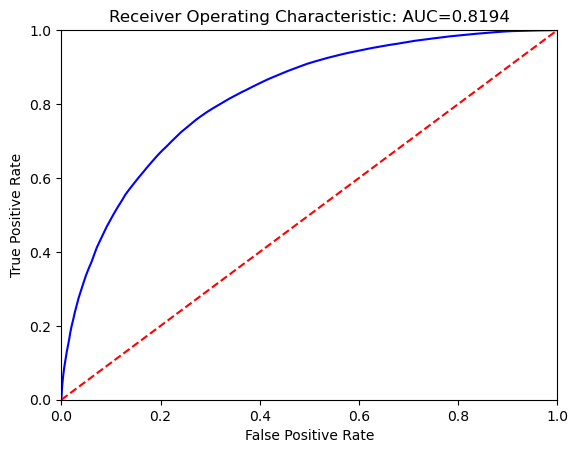

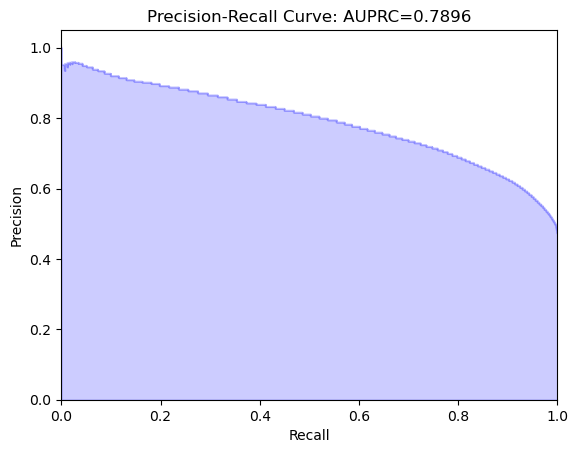

In [27]:
print("RandomForest:")

rf= RandomForestClassifier(random_state=1234)
start = time.time()
rf.fit(X_train_default,y_train_default)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test_default)
result = PlotROCCurve(probs[:,1],y_test_default, ci=confidence_interval, random_seed=random_seed)

results = ["RF_base"]
results.extend(result)
results.append(runtime)
result_list_rf.append(results)

(ii) Base variables but applied one-hot encoding on "gender" and feature scale numeric variables

RandomForest:
Training time: 88.47961735725403 seconds
AUC: 0.8196621877079088
AUPRC: 0.7902289156981053
Sensitivity: 0.7600278451235027
Specificity: 0.728160350982838
Score thresold: 0.4876838076072889
2.5 97.5


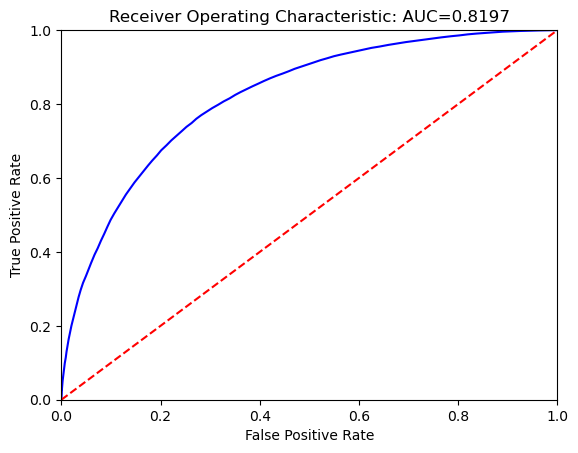

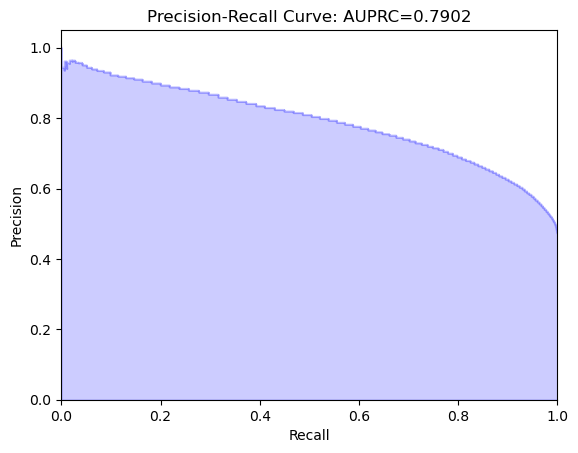

In [28]:
print("RandomForest:")

rf= RandomForestClassifier(random_state=1234)
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["RF_base_variables_with_features_caling"]
results.extend(result)
results.append(runtime)
result_list_rf.append(results)

In [29]:
# Feature importance for RF model
rf_feature_importance = pd.DataFrame(
        {
            'features': np.array(X_train.columns),    
            'importance' : rf.feature_importances_
            })

# Check top 20 features
rf_feature_importance.sort_values(by='importance',key=lambda x:abs(x),ascending=False)[:20]

,features,importance
0,age,0.124751
63,triage_acuity,0.111264
60,triage_sbp,0.087464
57,triage_heartrate,0.085696
61,triage_dbp,0.083133
56,triage_temperature,0.079115
62,triage_pain,0.047798
59,triage_o2sat,0.043903
58,triage_resprate,0.040046
52,n_hosp_365d,0.028379


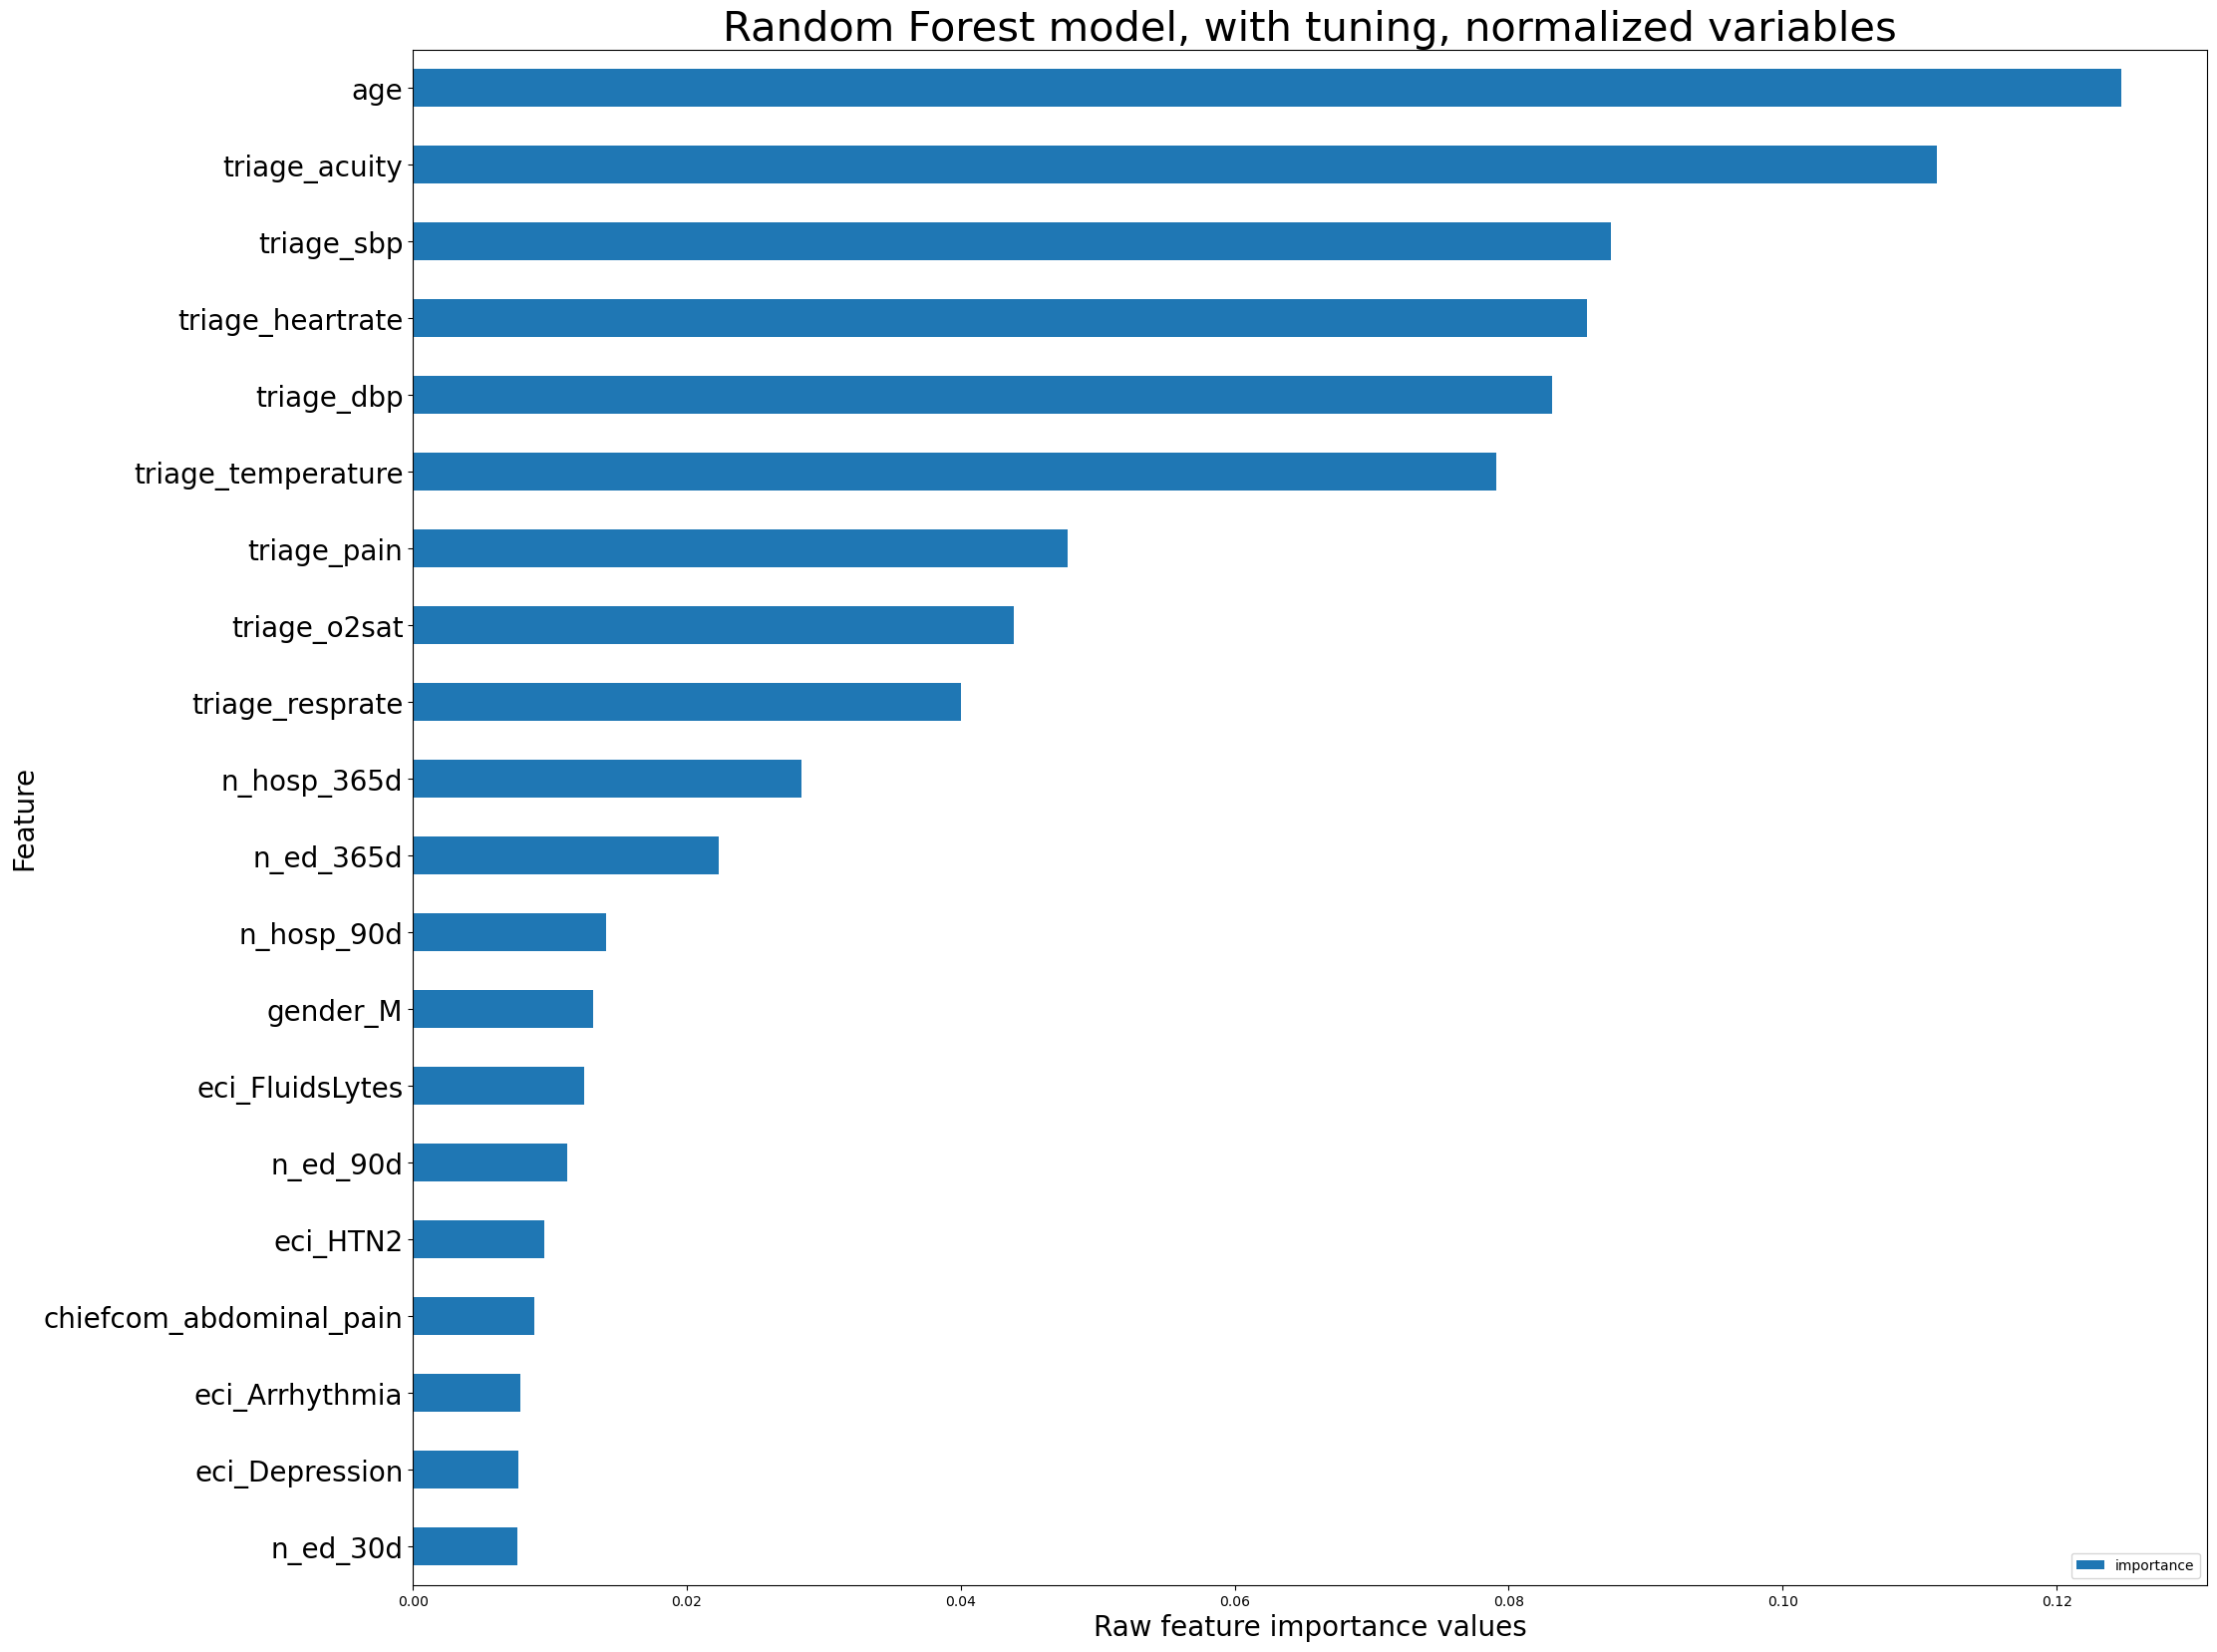

In [30]:
# Plot feature importance bar chart

sorted_feature_importance = rf_feature_importance.sort_values(by='importance',key=lambda x:abs(x),ascending=False)[:20].set_index('features')

sorted_feature_importance.sort_values(by='importance',key=lambda x:abs(x)).plot.barh(figsize=(30, 20))
plt.title("Random Forest model, with tuning, normalized variables", fontsize=30)
plt.xlabel("Raw feature importance values", fontsize=20)
plt.ylabel('Feature',fontsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

(iii) Performance Output for RF modelling

In [31]:
#result_df = pd.read_csv(os.path.join(path, 'result_hospitalization_triage.csv'))
result_df = pd.DataFrame(result_list_rf, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
#result_df.to_csv(os.path.join(path, 'result_hospitalization_triage.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
#formatted_result_df.to_csv(os.path.join(path, 'task1.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,RF_base,0.484,0.819 (0.817-0.821),0.79 (0.786-0.792),0.758 (0.74-0.762),0.728 (0.725-0.743),89.67
1,RF_base_variables_with_features_caling,0.488,0.82 (0.817-0.822),0.79 (0.786-0.793),0.76 (0.74-0.762),0.728 (0.725-0.748),88.48


#### c. Gradient Boosting

In [32]:
# Containers for all results
result_list_gb = []

(i) Base Model as per sample codes

GradientBoosting:
Training time: 66.81992173194885 seconds
AUC: 0.8186852978220994
AUPRC: 0.7958444377559575
Sensitivity: 0.7472094865455243
Specificity: 0.7320099789238247
Score thresold: 0.48262434212362276
2.5 97.5


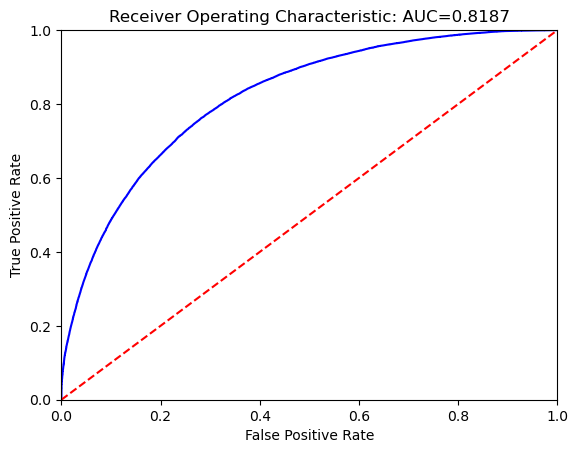

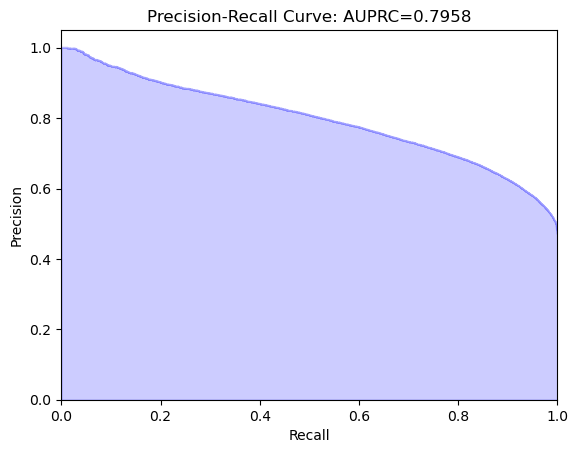

In [33]:
print("GradientBoosting:")

gb = GradientBoostingClassifier(random_state=1234)
start = time.time()
gb.fit(X_train_default,y_train_default)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test_default)
result = PlotROCCurve(probs[:,1],y_test_default, ci=confidence_interval, random_seed=random_seed)

results = ["GB_base"]
results.extend(result)
results.append(runtime)
result_list_gb.append(results)

(ii) Base variables but applied one-hot encoding on "gender" and feature scale numeric variables

GradientBoosting:
Training time: 66.61391401290894 seconds
AUC: 0.8186852978220994
AUPRC: 0.7958444377559575
Sensitivity: 0.7472094865455243
Specificity: 0.7320099789238247
Score thresold: 0.48262434212362276
2.5 97.5


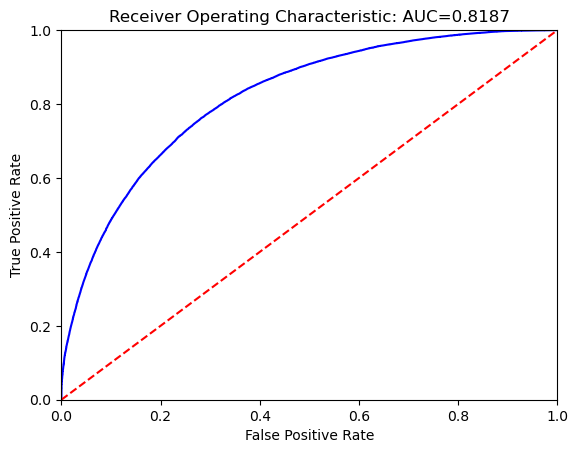

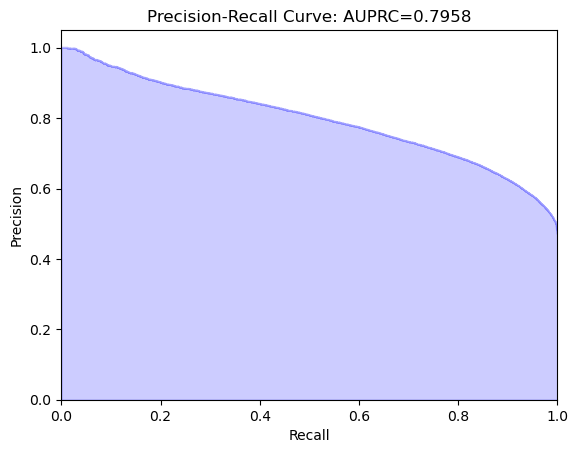

In [34]:
print("GradientBoosting:")

gb = GradientBoostingClassifier(random_state=1234)
start = time.time()
gb.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB_base_variables_with_features_caling"]
results.extend(result)
results.append(runtime)
result_list_gb.append(results)

In [35]:
# Feature importance for GB model
gb_feature_importance = pd.DataFrame(
        {
            'features': np.array(X_train.columns),    
            'importance' : gb.feature_importances_
            })

# Check top 20 features
gb_feature_importance.sort_values(by='importance',key=lambda x:abs(x),ascending=False)[:20]

,features,importance
63,triage_acuity,0.493469
0,age,0.196007
52,n_hosp_365d,0.089372
59,triage_o2sat,0.034327
51,n_hosp_90d,0.026128
39,eci_FluidsLytes,0.021138
62,triage_pain,0.015975
49,n_ed_365d,0.013899
56,triage_temperature,0.012744
57,triage_heartrate,0.012487


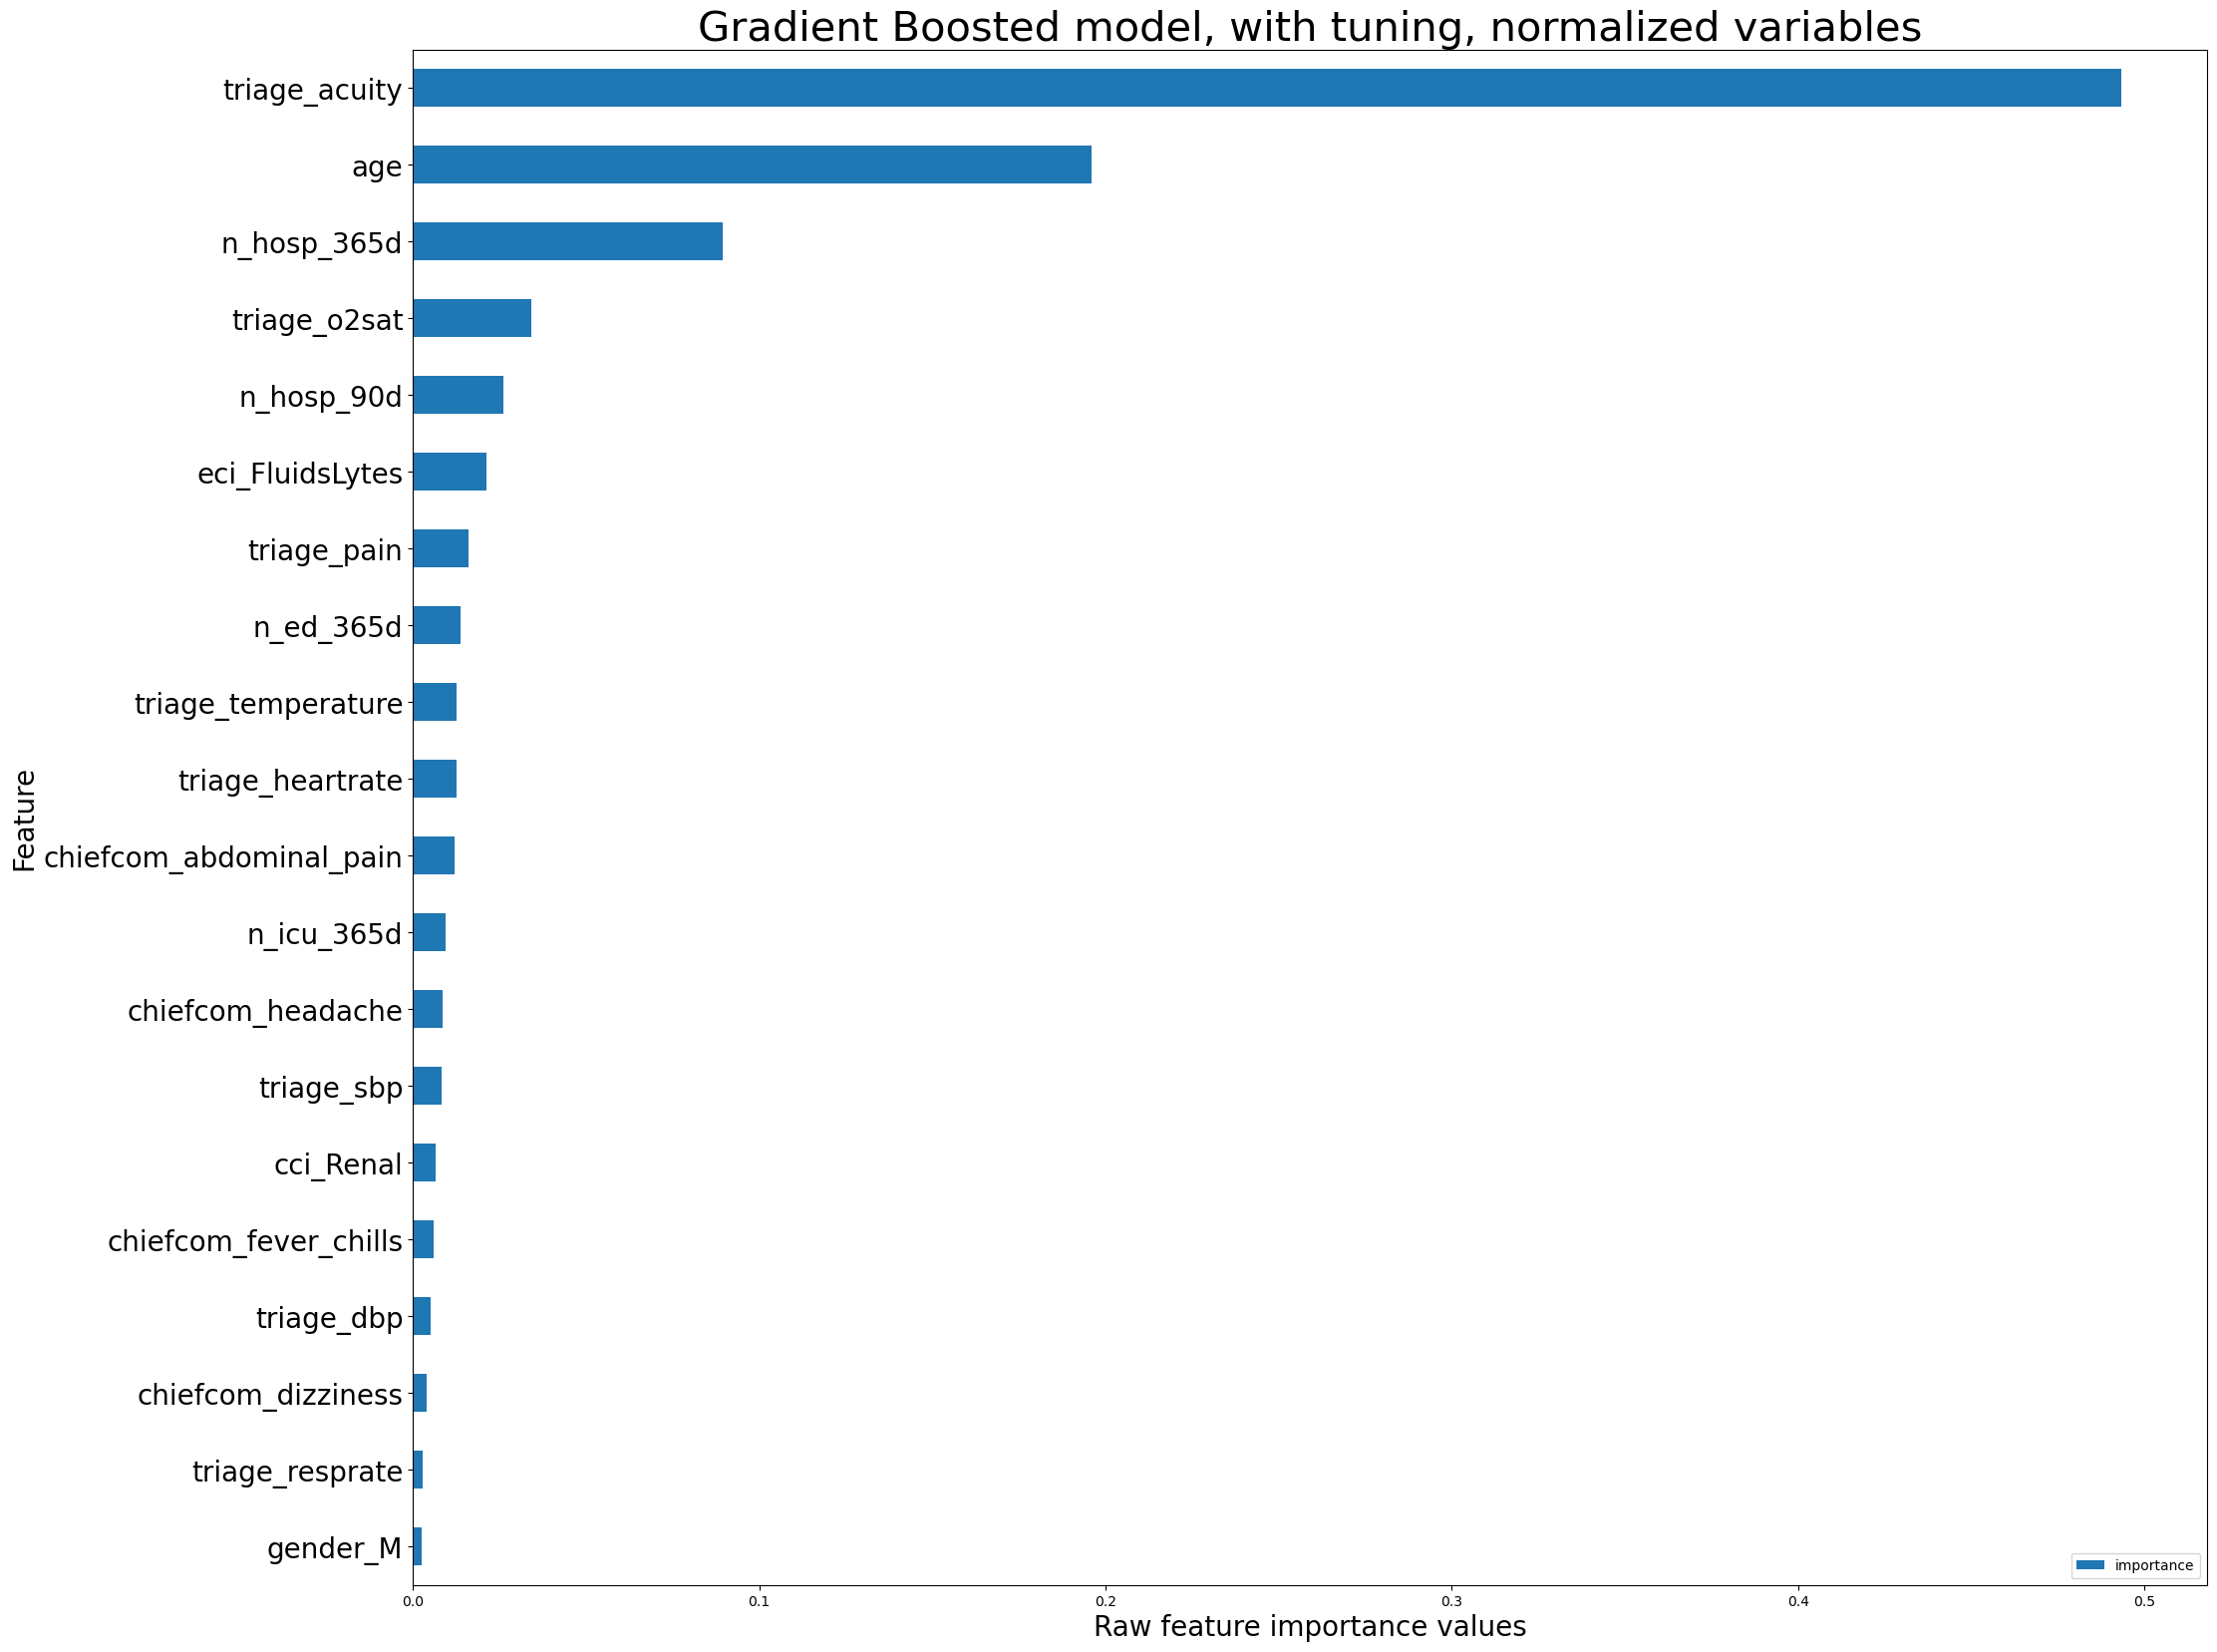

In [36]:
# Plot feature importance bar chart

sorted_feature_importance = gb_feature_importance.sort_values(by='importance',key=lambda x:abs(x),ascending=False)[:20].set_index('features')

sorted_feature_importance.sort_values(by='importance',key=lambda x:abs(x)).plot.barh(figsize=(30, 20))
plt.title("Gradient Boosted model, with tuning, normalized variables", fontsize=30)
plt.xlabel("Raw feature importance values", fontsize=20)
plt.ylabel('Feature',fontsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)


(vi) Performance Output for GB modelling

In [37]:
#result_df = pd.read_csv(os.path.join(path, 'result_hospitalization_triage.csv'))
result_df = pd.DataFrame(result_list_gb, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
#result_df.to_csv(os.path.join(path, 'result_hospitalization_triage.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
#formatted_result_df.to_csv(os.path.join(path, 'task1.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,GB_base,0.483,0.819 (0.816-0.821),0.796 (0.792-0.798),0.747 (0.742-0.761),0.732 (0.717-0.738),66.820
1,GB_base_variables_with_features_caling,0.483,0.819 (0.816-0.821),0.796 (0.792-0.798),0.747 (0.742-0.761),0.732 (0.717-0.738),66.614


#### d. MLP

In [38]:
# Containers for all results
result_list_mlp = []

(i) Base Model as per sample codes

In [39]:
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

In [40]:
# skip this cell if not retraining
mlp = MLP()
mlp.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train_default.astype(np.float32), y_train_default, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
#mlp.save('hospitalization_triage_mlp')

Epoch 1/20
1764/1764 [==============================] - 3s 1ms/step - loss: 0.5739 - accuracy: 0.7110 - auc: 0.7792 - auprc: 0.7499 - true_positives: 111875.0000 - true_negatives: 138860.0000 - precision: 0.7052 - recall: 0.6699
Epoch 2/20
1764/1764 [==============================] - 2s 1ms/step - loss: 0.5393 - accuracy: 0.7276 - auc: 0.8028 - auprc: 0.7790 - true_positives: 116080.0000 - true_negatives: 140492.0000 - precision: 0.7200 - recall: 0.6951
Epoch 3/20
1764/1764 [==============================] - 2s 1ms/step - loss: 0.5326 - accuracy: 0.7314 - auc: 0.8078 - auprc: 0.7841 - true_positives: 117640.0000 - true_negatives: 140287.0000 - precision: 0.7218 - recall: 0.7045
Epoch 4/20
1764/1764 [==============================] - 2s 1ms/step - loss: 0.5306 - accuracy: 0.7316 - auc: 0.8090 - auprc: 0.7855 - true_positives: 118538.0000 - true_negatives: 139445.0000 - precision: 0.7196 - recall: 0.7098
Epoch 5/20
1764/1764 [==============================] - 2s 1ms/step - loss: 0.5271 -

MLP:
2755/2755 [==============================] - 1s 508us/step
AUC: 0.8220573061162639
AUPRC: 0.7988271522065025
Sensitivity: 0.7628123574737752
Specificity: 0.7265043657791733
Score thresold: 0.41037935
2.5 97.5


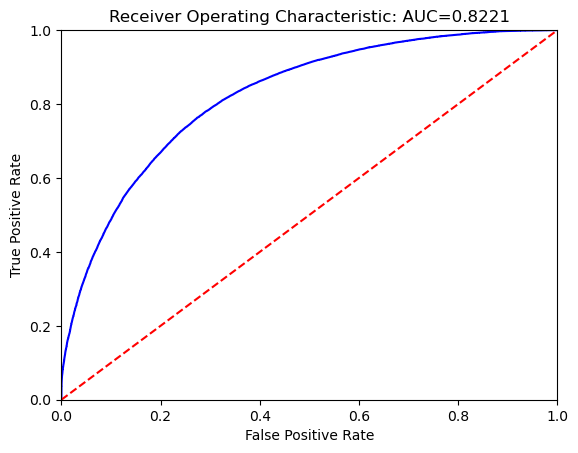

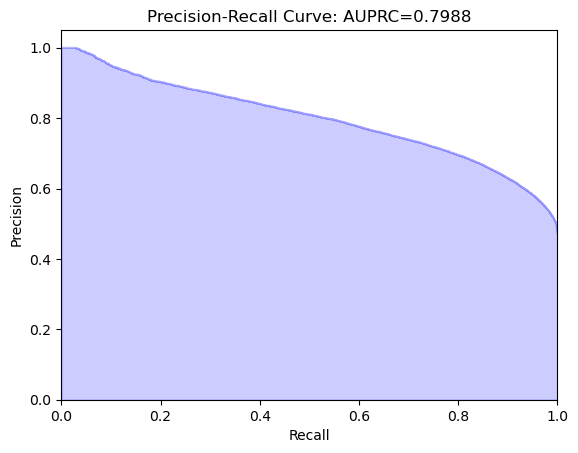

In [41]:
print("MLP:")
#mlp = load_model('hospitalization_triage_mlp')
probs = mlp.predict(X_test_default.astype(np.float32))
result = PlotROCCurve(probs,y_test_default, ci=confidence_interval, random_seed=random_seed)
results = ["MLP_base"]
results.extend(result)
results.append(runtime)
result_list_mlp.append(results)

(ii) Base variables but applied one-hot encoding on "gender" and feature scale numeric variables

In [42]:
# skip this cell if not retraining
mlp = MLP()
mlp.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
#mlp.save('hospitalization_triage_mlp')

Epoch 1/20
1764/1764 [==============================] - 3s 1ms/step - loss: 0.5713 - accuracy: 0.7069 - auc: 0.7778 - auprc: 0.7438 - true_positives: 111126.0000 - true_negatives: 138160.0000 - precision: 0.7007 - recall: 0.6654
Epoch 2/20
1764/1764 [==============================] - 2s 1ms/step - loss: 0.5358 - accuracy: 0.7282 - auc: 0.8044 - auprc: 0.7755 - true_positives: 117797.0000 - true_negatives: 138987.0000 - precision: 0.7163 - recall: 0.7054
Epoch 3/20
1764/1764 [==============================] - 2s 1ms/step - loss: 0.5325 - accuracy: 0.7299 - auc: 0.8068 - auprc: 0.7785 - true_positives: 119934.0000 - true_negatives: 137462.0000 - precision: 0.7134 - recall: 0.7182
Epoch 4/20
1764/1764 [==============================] - 2s 1ms/step - loss: 0.5284 - accuracy: 0.7335 - auc: 0.8100 - auprc: 0.7831 - true_positives: 121371.0000 - true_negatives: 137283.0000 - precision: 0.7151 - recall: 0.7268
Epoch 5/20
1764/1764 [==============================] - 2s 1ms/step - loss: 0.5262 -

MLP:
2755/2755 [==============================] - 1s 489us/step
AUC: 0.8196577990987788
AUPRC: 0.7953057928445092
Sensitivity: 0.7483376941357209
Specificity: 0.7346122413867263
Score thresold: 0.54701656
2.5 97.5


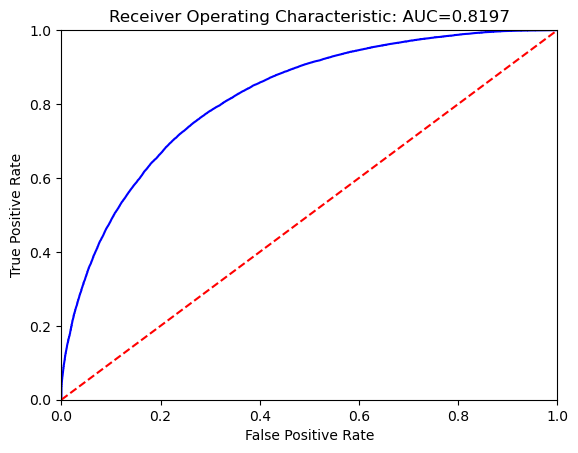

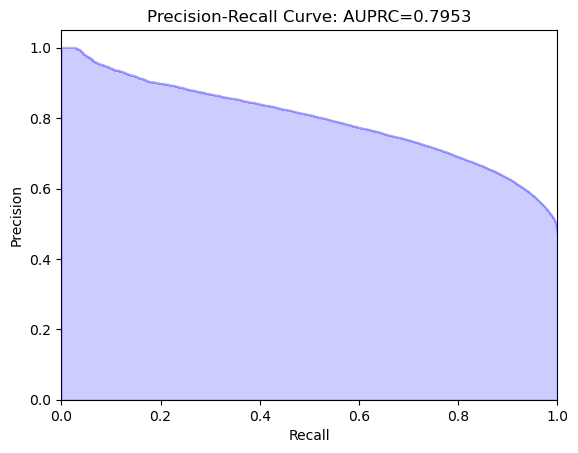

In [43]:
print("MLP:")
#mlp = load_model('hospitalization_triage_mlp')
probs = mlp.predict(X_test.astype(np.float32))
result = PlotROCCurve(probs,y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP_base_variables_with_features_caling"]
results.extend(result)
results.append(runtime)
result_list_mlp.append(results)

(iii) Performance Output for MLP

In [44]:
#result_df = pd.read_csv(os.path.join(path, 'result_hospitalization_triage.csv'))
result_df = pd.DataFrame(result_list_mlp, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
#result_df.to_csv(os.path.join(path, 'result_hospitalization_triage.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
#formatted_result_df.to_csv(os.path.join(path, 'task1.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,MLP_base,0.410,0.822 (0.82-0.824),0.799 (0.795-0.802),0.763 (0.744-0.766),0.727 (0.724-0.745),42.201
1,MLP_base_variables_with_features_caling,0.547,0.82 (0.817-0.822),0.795 (0.791-0.798),0.748 (0.743-0.758),0.735 (0.726-0.739),42.660
